Todo: Description

In [39]:
import os
import pprint
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sn

from tqdm import tqdm
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import *

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Preprocessing

We load all the files contained in different folders and create a dataset containing all information

In [85]:
base_data_path =  './data/BreaKHis_v1/histology_slides/breast'
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']
sub_classes = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

In [3]:
dataset = pd.DataFrame()
for clazz in tqdm(classes):
    for sub_clazz in sub_classes[clazz]:
        path = os.path.join(base_data_path, clazz, "SOB", sub_clazz)
        for id in os.listdir(path):
            for magnification in magnifications:
                path_to_files = os.path.join(path, id, magnification)
                for file_name in os.listdir(path_to_files):
                    dataset = dataset.append({
                        'id': id,
                        'path': os.path.join(path_to_files, file_name),
                        'magnification': magnification,
                        'type': sub_clazz,
                        'lesion': clazz
                }, ignore_index=True)

dataset

100%|██████████| 2/2 [00:15<00:00,  7.84s/it]


,id,lesion,magnification,path,type
0,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
1,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
2,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
3,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
4,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
...,...,...,...,...,...
7904,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7905,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7906,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7907,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma


We read the images contained in the dataset as follows:

1. Load the images as arrays using keras.prepocessing

2. Resize them keeping proportions: from *700x460* to *256x168* using *nearest* interpolation.<br>
We need to resize the images due to limited resources

3. Scale their values to a range from 0 to 1 before feeding the network

Then the shape of multidimensional array containing all the images (*x*) is (7909, 168, 256, 3)

In [4]:
n_samples = (len(dataset), )
image_size = (168, 256, 3)
x = np.empty(n_samples + image_size, dtype=np.float32)
for i, path in tqdm(enumerate(dataset["path"])):
    image = keras.preprocessing.image.load_img(path, target_size=image_size)
    x[i, :, :, :] = keras.preprocessing.image.img_to_array(image) / 255.0

7909it [01:29, 88.27it/s] 


In order to classify the images, we need to encode their labels (*lesion* and *type*).<br>
Then we use the *sklearn.preprocessing.LabelEncoder* to achieve this goal.

Since lesion can be either *bening* or *malignant*, we are going to perform a binary classification to identify it.<br>

Instead, we have 8 different types of lesions: 4 for the bening samples, 4 for the malignant ones.
Then, to identify the type of the lesion we need to perform a multiclass classification

Hence, at the end we will have the binary labels in *y_binary* and the multiclass ones in *y_multiclass*

In [5]:
binary_encoder = LabelEncoder()
binary_encoder.fit(classes)
y_binary = binary_encoder.transform(dataset["lesion"])

multiclass_encoder = LabelEncoder()
multiclass_encoder.fit([sub_class for l in sub_classes.values() for sub_class in l])
y_multiclass = multiclass_encoder.transform(dataset["type"])

We split the our dataset in training and test set: we use 70$ of the samples for training and 30% for testing as specified in the paper.

In order to perform two different types of classification with the same training set, we split the dataset specifying the *random_state* (details [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) to get the correct labels in the multiclass split as well

In [6]:
x_train, x_test, y_train_binary, y_test_binary = \
    train_test_split(x, y_binary, test_size=0.3, shuffle=True, random_state=42)

_, _, y_train_multiclass, y_test_multiclass = \
    train_test_split(x, y_multiclass, test_size=0.3, shuffle=True, random_state=42)

### KNN classifier

First of all, we perform an "easy" classification using a *KNN* classifier for both cases: binary and multiclass.

To do so, we need to flatten our arrays using *numpy*

In [11]:
flattened_x_train = np.empty((len(x_train), np.prod(image_size)))
for i, image in tqdm(enumerate(x_train)):
    flattened_x_train[i][:] = image.flatten()

flattened_x_test = np.empty((len(x_test), np.prod(image_size)))
for i, image in tqdm(enumerate(x_test)):
    flattened_x_test[i][:] = image.flatten()

5536it [00:01, 3027.21it/s]
2373it [00:06, 355.50it/s]


We define a dictionary containing dictionaries to keep all the reports

In [12]:
knn_reports = {
    "binary": {},
    "multiclass": {}
}

Then we perform the classification using *sklearn.neighbors.KNeighborsClassifier*

NB:

1. it wasn't possible to perform KNN classification with data augmentation due to limited resources
2. in order to speed up the process, we have already computed which is the best k: 14 for both classifications.

In [13]:
best_k_binary = 14
best_k_multiclass = 14

# binary classifier
knn_binary = KNeighborsClassifier(n_neighbors=best_k_binary)
knn_binary.fit(flattened_x_train, y_train_binary)
knn_reports["binary"][best_k_binary] = classification_report(y_test_binary, \
    knn_binary.predict(flattened_x_test), output_dict=True)

# multiclass classifier
knn_multiclass = KNeighborsClassifier(n_neighbors=best_k_multiclass)
knn_multiclass.fit(flattened_x_train, y_train_multiclass)
knn_reports["multiclass"][best_k_multiclass] = classification_report(y_test_multiclass, \
    knn_multiclass.predict(flattened_x_test), output_dict=True)

"""
for k in tqdm(range(1, 20)):
    # binary classifier
    knn_binary = KNeighborsClassifier(n_neighbors=k)
    knn_binary.fit(flatten_x_train_binary, y_train_binary)
    knn_reports["binary"][k] = classification_report(y_test_binary, \
        knn_binary.predict(flatten_x_test_binary), output_dict=True)
    # multiclass classifier
    knn_multiclass = KNeighborsClassifier(n_neighbors=k)
    knn_multiclass.fit(flatten_x_train_multiclass, y_train_multiclass)
    knn_reports["multiclass"][k] = classification_report(y_test_multiclass, \
        knn_multiclass.predict(flatten_x_test_multiclass), output_dict=True)


best_k_binary = max(knn_results["binary"], key = lambda k: knn_reports[k]["accuracy"])
knn_reports["binary"][best_k_binary]
best_k_multiclass = max(knn_results["multiclass"], key = lambda k: knn_reports[k]["accuracy"])
knn_reports["multiclass"][best_k_multiclass]
"""

pprint.pprint(knn_reports)

{'binary': {14: {'0': {'precision': 0.8208092485549133,
    'recall': 0.5454545454545454,
    'f1-score': 0.6553846153846155,
    'support': 781},
   '1': {'precision': 0.8085221143473571,
    'recall': 0.9415829145728644,
    'f1-score': 0.8699941961694719,
    'support': 1592},
   'accuracy': 0.8112094395280236,
   'macro avg': {'precision': 0.8146656814511353,
    'recall': 0.7435187300137049,
    'f1-score': 0.7626894057770437,
    'support': 2373},
   'weighted avg': {'precision': 0.8125660468446607,
    'recall': 0.8112094395280236,
    'f1-score': 0.7993620501125934,
    'support': 2373}}},
 'multiclass': {14: {'0': {'precision': 0.212707182320442,
    'recall': 0.506578947368421,
    'f1-score': 0.29961089494163423,
    'support': 152},
   '1': {'precision': 0.5845755022683085,
    'recall': 0.8817204301075269,
    'f1-score': 0.7030397505845674,
    'support': 1023},
   '2': {'precision': 0.3360655737704918,
    'recall': 0.128125,
    'f1-score': 0.1855203619909502,
    'supp

As can be seen by the reports above, the *KNN* classifier doesn't seem to perform well in this experiment, at least without data augmentation 

## Data augmentation

As done in the experiment discussed in the paper, we perform data augmentation.<br>
To achieve this goal we use the image generator defined by *keras.preprocessing.image*.

The parameters that we choose for the image generator are the same as those defined in the paper. <br>
On the other hand, the number of samples generated is about 50% of the 166.068 used in the paper due to limited resources.

In [15]:
image_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

Since we are gonna to use a *keras model* we need to convert our labels in one-hot encoding.<br>
To do so, we use the method *to_categorial* defined in *keras.utils* and we split again the dataset as done before

In [16]:
y_binary_categorical = keras.utils.to_categorical(y_binary, 2)
y_multiclass_categorical = keras.utils.to_categorical(y_multiclass, 8)

_, _, y_train_binary, y_test_binary = \
    train_test_split(x, y_binary_categorical , test_size=0.3, shuffle=True, random_state=42)

_, _, y_train_multiclass, y_test_multiclass = \
    train_test_split(x, y_multiclass_categorical, test_size=0.3, shuffle=True, random_state=42)

Once all the sets are ready, we can augment our train set. The new train set is a dictionary containing:
- *x*: a numpy array containing all the images. Its shape is (*|x_train|* \* *number_of_iteration*, 168, 256, 3)
- *classes*: a numpy array containing all binary labels. Its shape is (*|x_train|* \* *number_of_iteration*, 2)
- *sub_classes*: a numpy array containing all multiclass labels. Its shape is (*|x_train|* \* *number_of_iteration*, 8)

In [17]:
n_iterations = 1
batch_size = len(x_train)

augmented_dataset = {
    "x": np.empty((batch_size * n_iterations, ) + image_size, dtype=np.float32),
    "classes": np.empty((batch_size * n_iterations, 2), dtype=np.int8),
    "sub_classes": np.empty((batch_size * n_iterations, 8), dtype=np.int8)
}

y_train = list(zip(y_train_binary, y_train_multiclass))
iterator = image_generator.flow(x_train, y_train, batch_size=batch_size, shuffle=True)

augmented_dataset["x"][:batch_size] = x_train
augmented_dataset["classes"][:batch_size] = y_train_binary
augmented_dataset["sub_classes"][:batch_size] = y_train_multiclass

for i in tqdm(range(1, n_iterations)):
    images = iterator.next()
    start_index = batch_size * i
    for j in range(batch_size):
        augmented_dataset["x"][start_index + j] = images[0][j]
        augmented_dataset["classes"][start_index + j] = images[1][j][0]
        augmented_dataset["sub_classes"][start_index + j] = images[1][j][1]

augmented_dataset["x"].shape

0it [00:00, ?it/s]


(5536, 168, 256, 3)

In order to visualize the data augmentation we define a function to visualize an image.<br>
Then we render 20 random images after augmentation using *matplotlib*

In [18]:
def plot_image(x, label):
    plt.imshow(x)
    plt.xlabel(label)
    plt.grid(False)

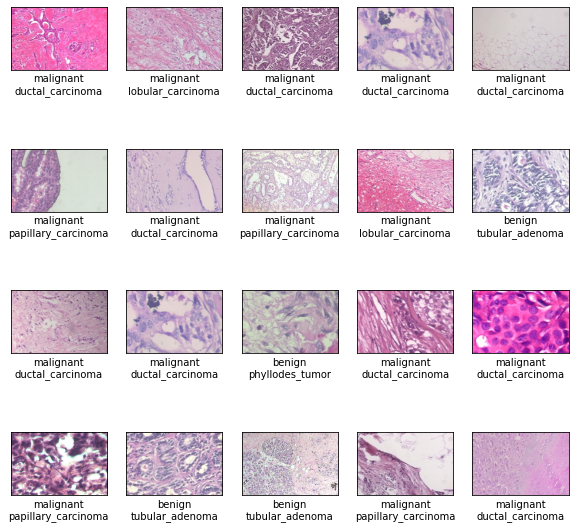

In [19]:
n_images = 20
random_indices = [random.randint(0, len(augmented_dataset["x"])) for _ in range(n_images)]
images = augmented_dataset["x"][random_indices, :, :, :]
class_labels = augmented_dataset["classes"][random_indices]
sub_class_labels = augmented_dataset["sub_classes"][random_indices]

plt.figure(figsize=(10, 10))
for i in range(n_images):
	plt.subplot(4, 5, i + 1)
	class_label = binary_encoder.inverse_transform(np.array([np.argmax(class_labels[i])]))[0]
	sub_class_label = multiclass_encoder.inverse_transform([np.argmax(sub_class_labels[i])])[0]
	plot_image(images[i], class_label + "\n" + sub_class_label)
	plt.xticks([])
	plt.yticks([])
plt.show()

Moreover, we define two more functions to visualize classification results

In [20]:
def plot_prediction_array(prediction, predicted_class, true_class):
    plt.grid(False)
    plt.xticks(range(len(prediction)))
    plt.yticks([])
    plot = plt.bar(range(len(prediction)), prediction, color="#777777")
    plot[predicted_class].set_color('red')
    plot[true_class].set_color('blue')

In [21]:
def plot_results(indices, x_test, y_test, y_predicted):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        image_index = indices[i]
        prediction = y_predicted[image_index]
        plt.subplot(4, 4, 2 * i + 1)
        percentage = round(max(prediction) * 100, 2)
        predicted_class = np.argmax(y_predicted[image_index])
        true_class = np.argmax(y_test[image_index])
        predicted_class_label = ""
        true_class_label = ""
        if len(y_test[0]) == 2:
            predicted_class_label = binary_encoder.inverse_transform([predicted_class])[0]
            true_class_label = binary_encoder.inverse_transform([true_class])[0]
        elif len(y_test[0]) == 8:
            predicted_class_label = multiclass_encoder.inverse_transform([predicted_class])[0]
            true_class_label = multiclass_encoder.inverse_transform([true_class])[0]
        x_label = str(predicted_class_label) + " " + str(percentage) + "%\n(" + str(true_class_label) + ")"
        plot_image(x_test[image_index], x_label)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 4, 2 * i + 2)
        plot_prediction_array(y_predicted[image_index], predicted_class, true_class)

## Deep models

### Definition of the model

As in the experiment discussed in the paper:
 - we set the number of epochs to 50

 - we use *SGD* as optimizer with *momentum* set to 0.9.<br>
 Hence, the update rule using momentum is:$velocity = momentum * velocity - ε * g$ => $w = w + velocity$
 
 - the learning rate decreases by a factor of 10 after 50 epochs

Since additional information aren't provided in the paper, we set the batch size, that is number of images generated using to compute the gradient, to 64 (as the literature recommends).

Then we set *steps_per_epoch = len(x_train) / batch_size*. This means that each epoch works on the whole training set, using *len(x_train) / batch_size* steps, processing *batch_size* images at each step.

Then total number of images processed during the training phase is: *len(x_train) \* number of epochs*

In [31]:
batch_size = 64
epochs = 1
steps_per_epoch = len(augmented_dataset["x"]) / batch_size

learning_rate_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 0.01,
    decay_steps = epochs,
    end_learning_rate = 0.001
)
optimizer = keras.optimizers.SGD(learning_rate=learning_rate_scheduler, momentum=0.9, name="SGD")

deep_model_results = {
    "binary": {},
    "multiclass": {}
}

In [32]:
def get_model(n_classes):
    model = keras.Sequential([
        InputLayer(input_shape=image_size),
        SeparableConv2D(32, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        SeparableConv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        SeparableConv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        SeparableConv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        SeparableConv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        SeparableConv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5)
    ])
    if n_classes > 2:
        model.add(Dense(n_classes, activation="softmax"))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    else:
        model.add(Dense(n_classes, activation="sigmoid"))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

### Binary model

In [29]:
get_model(2).summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_6 (Separabl (None, 168, 256, 32)      155       
_________________________________________________________________
batch_normalization_7 (Batch (None, 168, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 84, 128, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 84, 128, 32)       0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 84, 128, 64)       2400      
_________________________________________________________________
batch_normalization_8 (Batch (None, 84, 128, 64)       256       
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 84, 128, 64)      

Fit the model

In [34]:
binary_model = get_model(2)
binary_model.fit(
    augmented_dataset["x"],
    augmented_dataset["classes"],
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size)
deep_model_results["binary"]["predictions"] = binary_model.predict(x_test)

86/86 [==============================] - 35s 383ms/step - loss: 0.6220 - accuracy: 0.7589


<AxesSubplot:>

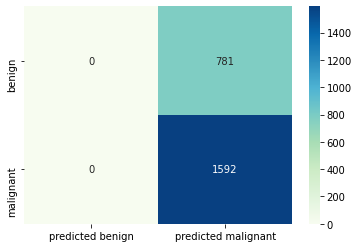

In [75]:
deep_model_results["binary"]["y_true"] = [np.argmax(array) for array in y_test_binary]
deep_model_results["binary"]["y_predicted"] = [np.argmax(array) for array in deep_model_results["binary"]["predictions"]]


sn.heatmap(
    data = confusion_matrix(deep_model_results["binary"]["y_true"], deep_model_results["binary"]["y_predicted"]),
    cmap = "GnBu",
    fmt= 'g',
    annot = True,
    xticklabels = ["predicted " + clazz for clazz in classes],
    yticklabels = classes
)

Visualize some binary classifications

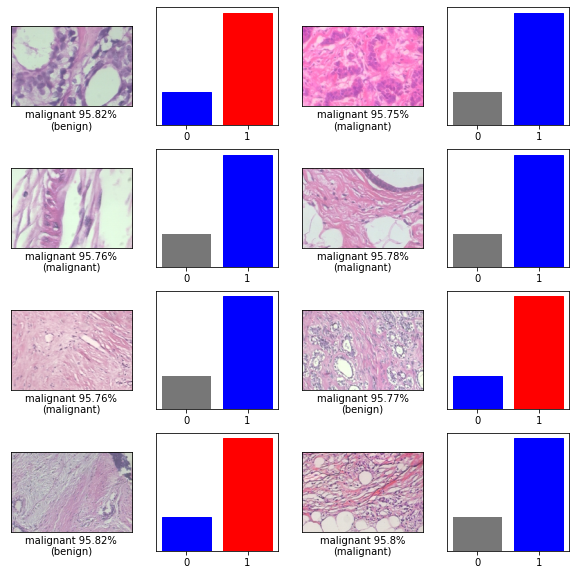

In [35]:
random_indices = [random.randint(1, len(y_test_binary)) for _ in range(16)]
plot_results(random_indices, x_test, y_test_binary, deep_model_results["binary"]["predictions"])

### Multiclass model

In [53]:
get_model(8).summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_24 (Separab (None, 168, 256, 32)      155       
_________________________________________________________________
batch_normalization_28 (Batc (None, 168, 256, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 84, 128, 32)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 84, 128, 32)       0         
_________________________________________________________________
separable_conv2d_25 (Separab (None, 84, 128, 64)       2400      
_________________________________________________________________
batch_normalization_29 (Batc (None, 84, 128, 64)       256       
_________________________________________________________________
separable_conv2d_26 (Separab (None, 84, 128, 64)      

Fit the model

In [54]:
multiclass_model = get_model(8)
multiclass_model.fit(
    augmented_dataset["x"],
    augmented_dataset["sub_classes"],
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size
)
deep_model_results["multiclass"]["predictions"] = multiclass_model.predict(x_test)

86/86 [==============================] - 34s 381ms/step - loss: 0.6542 - accuracy: 0.3438


<AxesSubplot:>

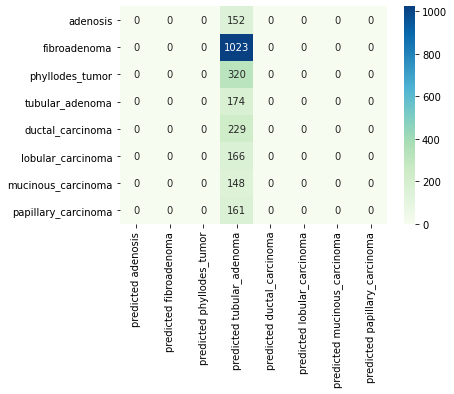

In [87]:
deep_model_results["multiclass"]["y_true"] = [np.argmax(array) for array in y_test_multiclass]
deep_model_results["multiclass"]["y_predicted"] = [np.argmax(array) for array in deep_model_results["multiclass"]["predictions"]]

sn.heatmap(
    data = confusion_matrix(
        deep_model_results["multiclass"]["y_true"],
        deep_model_results["multiclass"]["y_predicted"]
    ),
    cmap = "GnBu",
    fmt= 'g',
    annot = True,
    xticklabels = ["predicted "  + sub_class for l in sub_classes.values() for sub_class in l],
    yticklabels = [sub_class for l in sub_classes.values() for sub_class in l]
)

Visualize some multiclass classifications

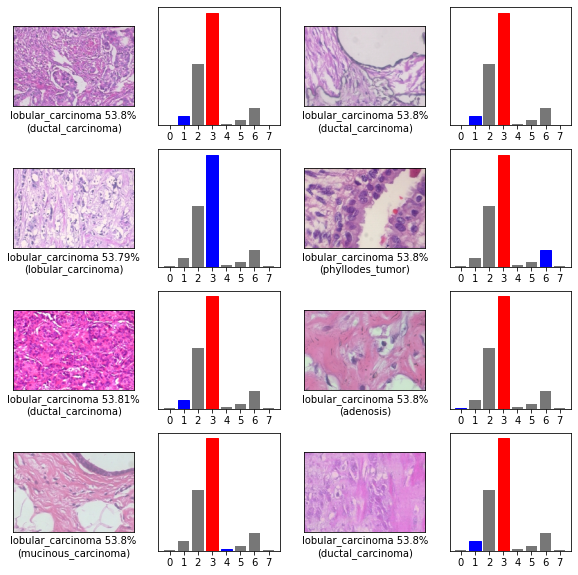

In [88]:
random_indices = [random.randint(1, len(y_test_multiclass)) for _ in range(16)]
plot_results(random_indices, x_test, y_test_multiclass, deep_model_results["multiclass"]["predictions"])

Visualize some metrics for the binary and the multiclass classifiers

In [89]:
def compute_stats(report, n_classes):
    accuracies = []
    recalls = [[] for _ in range(n_classes)]
    for clazz in range(n_classes):
        recalls[clazz].append(report[str(clazz)]["recall"]) 
    accuracies.append(report["accuracy"])
    return np.mean(accuracies), [np.mean(clazz) for clazz in recalls]

In [90]:
def plot_stats(deep_model_accuracy, deep_model_stats, knn_accuracy, knn_stats, x_label, y_label):
    print("Average accuracy of the knn classifier: " + str(knn_accuracy))
    print("Average accuracy of the deep model: " + str(deep_model_accuracy))
    print()
    width = 0.25
    x = [i for i in range(0, len(deep_model_stats))]
    fig, ax = plt.subplots()
    ax.bar([clazz - width for clazz in x], knn_stats, width, label="knn")
    ax.bar([clazz for clazz in x], deep_model_stats, width, label="deep model")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_yticks([0.20, 0.45, 0.60, 0.80, 1])
    ax.set_ylim([0, 1.07])
    ax.legend()
    plt.show()

In [91]:
binary_report = classification_report(deep_model_results["binary"]["y_true"], deep_model_results["binary"]["y_predicted"], output_dict=True)

Average accuracy of the knn classifier: 0.8112094395280236
Average accuracy of the deep model: 0.6708807416772019



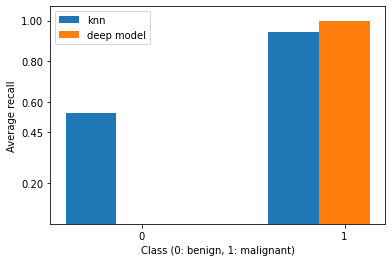

In [92]:
deep_model_accuracy, deep_model_recalls = compute_stats(binary_report, 2)
knn_accuracy, knn_recalls = compute_stats(knn_reports["binary"][best_k_binary], 2)
plot_stats(
    deep_model_accuracy,
    deep_model_recalls,
    knn_accuracy,
    knn_recalls,
    "Class (0: benign, 1: malignant)", "Average recall")

In [93]:
multiclass_report = classification_report(deep_model_results["multiclass"]["y_true"], deep_model_results["multiclass"]["y_predicted"], output_dict=True)

Average accuracy of the knn classifier: 0.46439106616097764
Average accuracy of the deep model: 0.07332490518331226



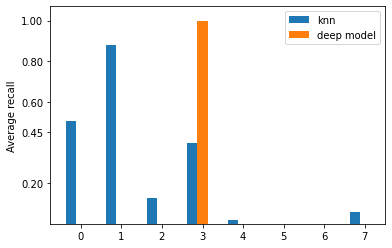

In [94]:
deep_model_accuracy, deep_model_recalls = compute_stats(multiclass_report, 8)
knn_accuracy, knn_recalls = compute_stats(knn_reports["multiclass"][best_k_multiclass], 8)
plot_stats(
    deep_model_accuracy,
    deep_model_recalls,
    knn_accuracy,
    knn_recalls,
    "", "Average recall"
)